In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 307M/309M [00:15<00:00, 22.6MB/s]
100% 309M/309M [00:15<00:00, 21.0MB/s]


In [5]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [6]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [7]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [8]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

# Data Preperation

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 2278 files belonging to 3 classes.


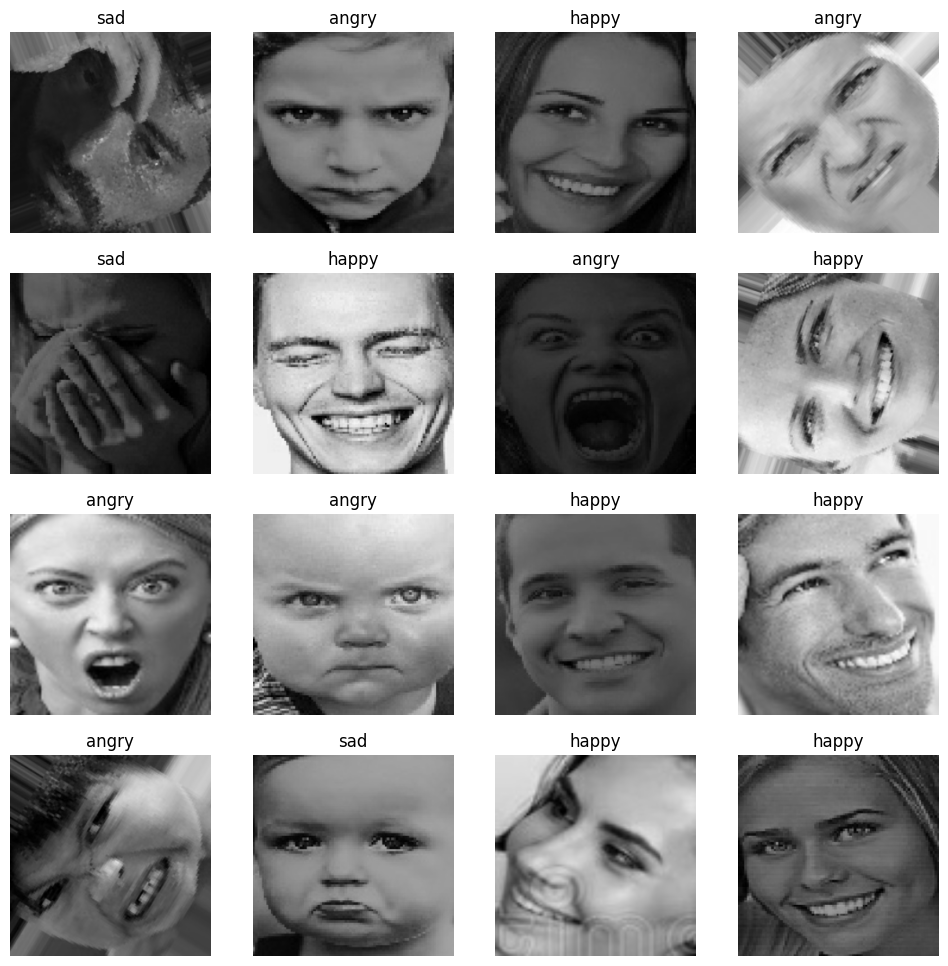

In [11]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

#Data Augmention

In [12]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [13]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [14]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [15]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [17]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [19]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Model

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [20]:
loss_function = CategoricalCrossentropy(
)

In [21]:
y_true = [[0, 0, 1], [1, 0, 0]]
y_pred = [[0.5, 0.40, 0.99], [0.99, 0.70, 0.50]]
loss_function(y_true, y_pred).numpy()

0.72028947

In [22]:
y_true = [2, 0]
y_pred = [[0.05, 0.05, 0.99], [0.99, 0.05, 0.05]]
sce = SparseCategoricalCrossentropy()
sce(y_true, y_pred).numpy()

0.09622802

In [23]:
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]

In [ ]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=2,
    verbose=1
)

Epoch 1/2
213/213 [==============================] - 78s 300ms/step - loss: 0.9857 - accuracy: 0.5436 - top_k_accuracy: 0.8200 - val_loss: 1.0660 - val_accuracy: 0.4100 - val_top_k_accuracy: 0.7774
Epoch 2/2
213/213 [==============================] - 75s 349ms/step - loss: 0.8211 - accuracy: 0.6263 - top_k_accuracy: 0.8667 - val_loss: 0.9357 - val_accuracy: 0.5645 - val_top_k_accuracy: 0.8222


#  Testing

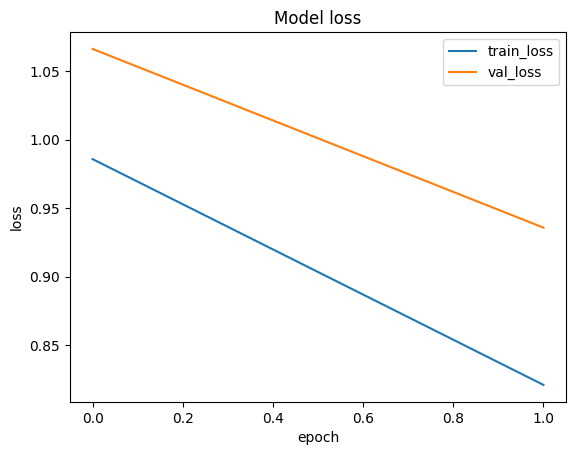

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

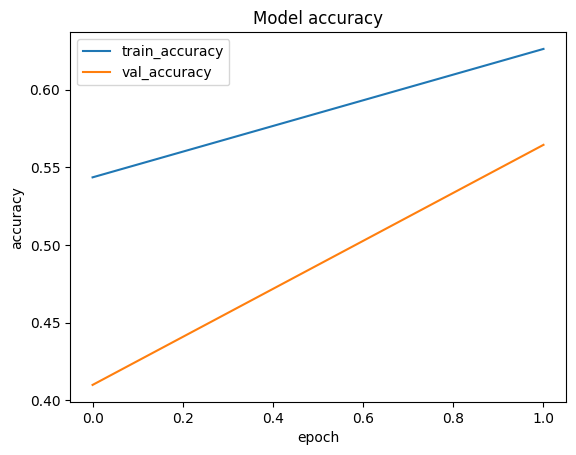

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
lenet_model.evaluate(validation_dataset)

2278/2278 [==============================] - 13s 6ms/step - loss: 0.9357 - accuracy: 0.5645 - top_k_accuracy: 0.8222


[0.9357237219810486, 0.5645303130149841, 0.8222124576568604]

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

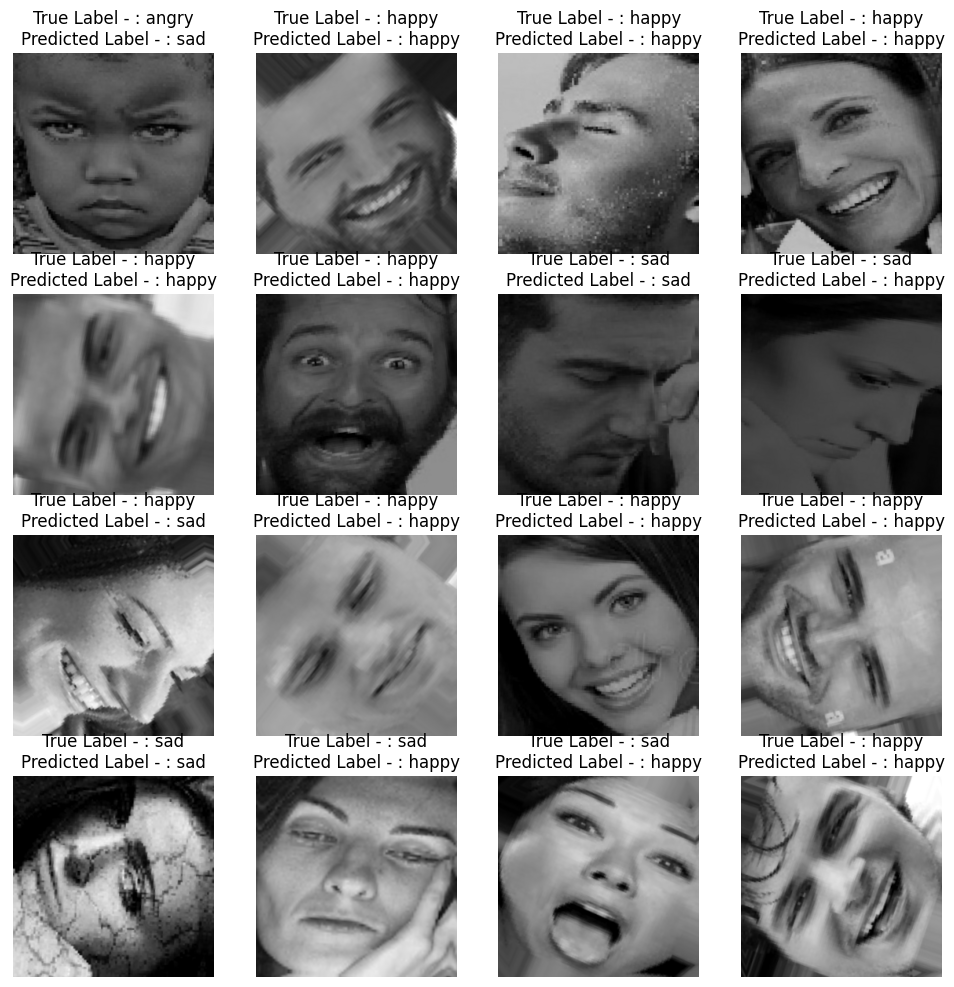

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in training_dataset.take(16):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
                  + "\n" + "Predicted Label - : "
                  + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")

# Cut mix data augmentation

In [24]:
def box(lamda):
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [25]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
train_dataset_1 = train_dataset.map(
    augment_layer,
    num_parallel_calls = tf.data.AUTOTUNE
    )
train_dataset_2 = train_dataset.map(
    augment_layer,
    num_parallel_calls = tf.data.AUTOTUNE
    )

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
training_dataset_cut_mix = (
     mixed_dataset
     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
     .prefetch(tf.data.AUTOTUNE)
 )

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [ ]:
training_dataset_cut_mix

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

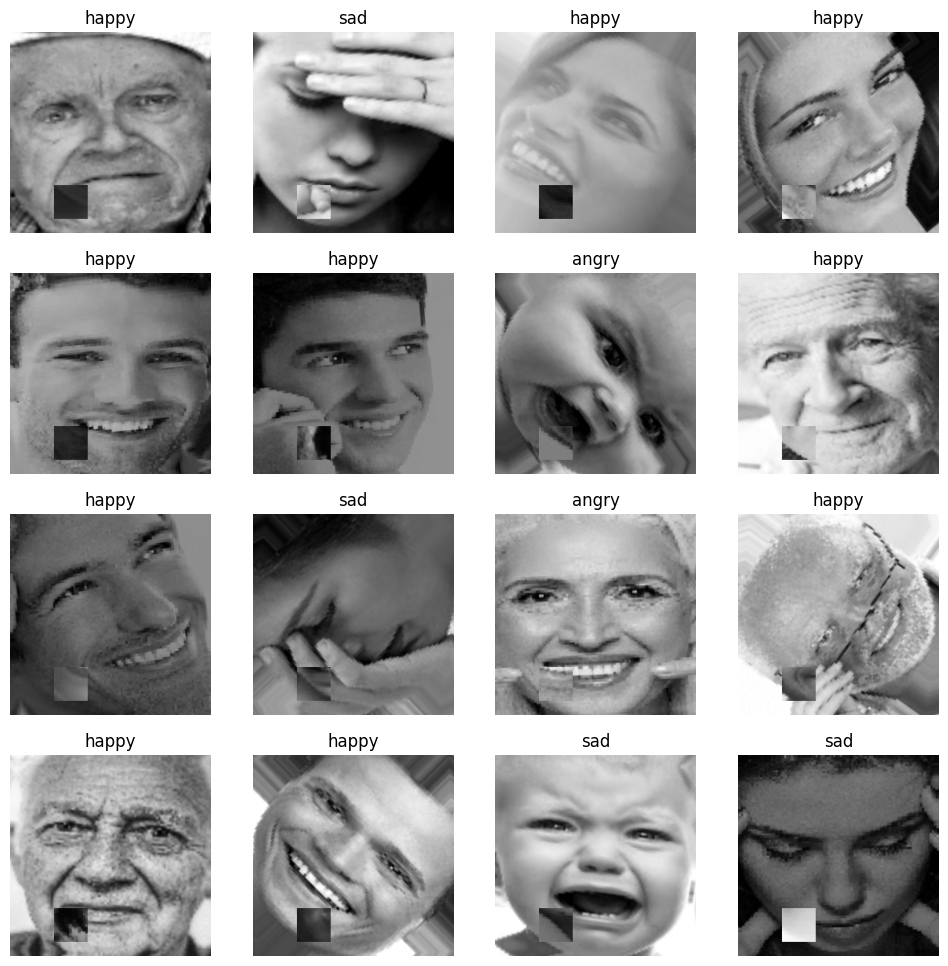

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in training_dataset_cut_mix.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im).numpy())
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 2 1 ... 1 0 1]
[1 2 1 ... 1 2 1]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[ 60 244 211]
 [  3 831 172]
 [ 15 347 395]]


Text(0.5, 58.7222222222222, 'Predicted')

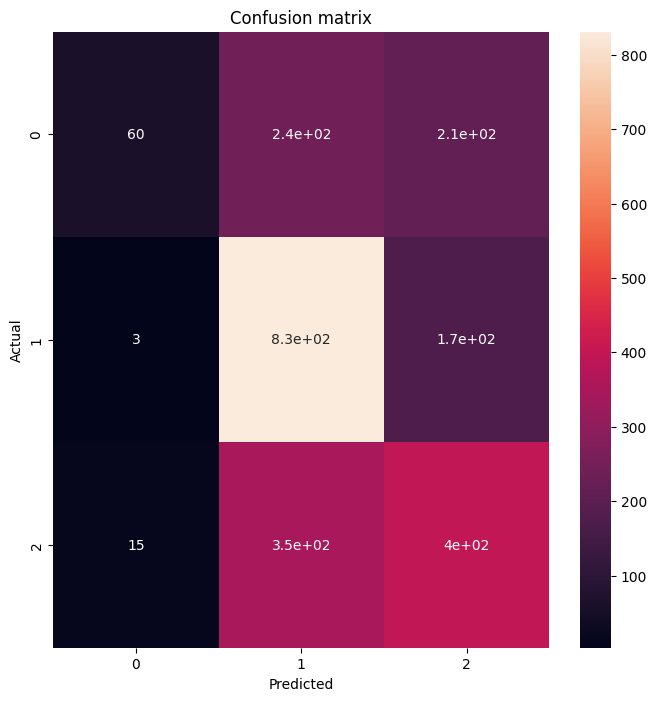

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# TFRecords

In [26]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [27]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
training_dataset_record = (
    train_dataset
    .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset_record = (
    val_dataset
)

In [ ]:
training_dataset_record = training_dataset_record.unbatch()

In [ ]:
validation_dataset_record = validation_dataset_record.unbatch()

In [28]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  training_dataset_record
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

NotFoundError: ignored

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
val_recons_dataset = tf.data.TFRecordDataset(
     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )

In [ ]:
recons_dataset

In [ ]:
def parse_tfrecords(example):
    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_parsed_dataset = (
     val_recons_dataset
     .map(parse_tfrecords)
     .batch(CONFIGURATION["BATCH_SIZE"])
     .prefetch(tf.data.AUTOTUNE)
 )

In [ ]:
parsed_dataset

In [ ]:
val_parsed_dataset

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

In [ ]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)

In [ ]:
history = lenet_model.fit(
    parsed_dataset,
    validation_data = val_parsed_dataset,
    epochs = 1,
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
lenet_model.evaluate(val_parsed_dataset)

In [ ]:
lenet_model

# RESNET

In [ ]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [29]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x


In [30]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [31]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

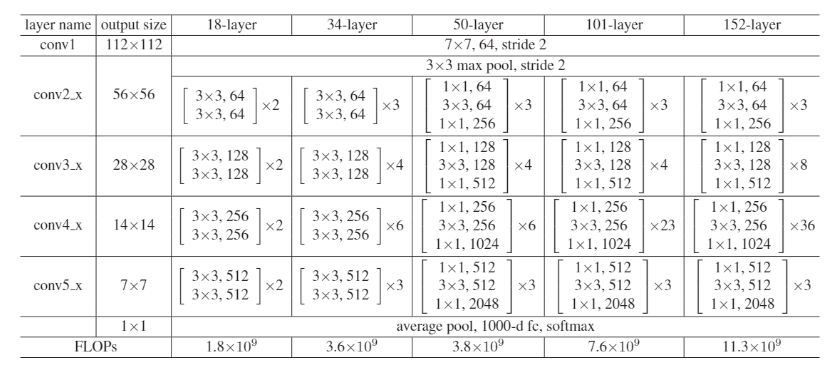

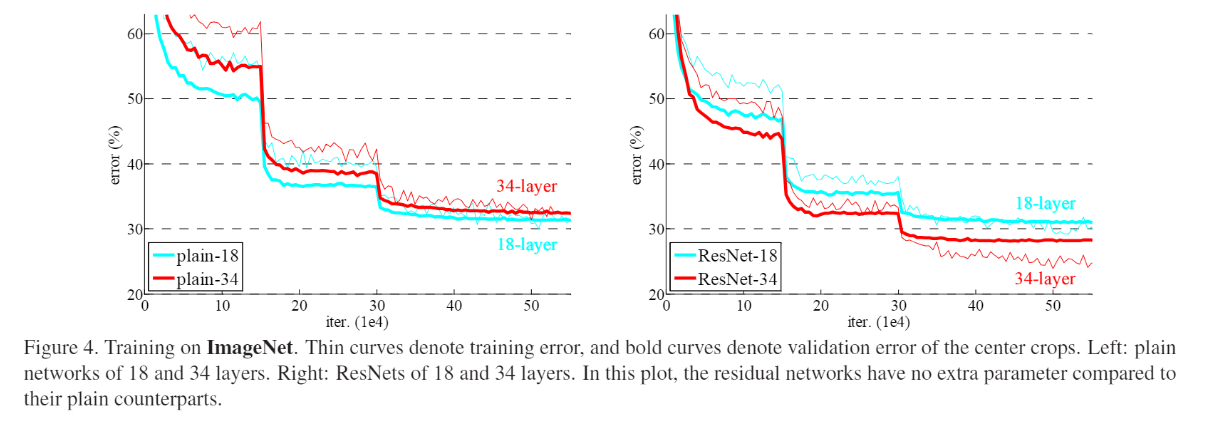

In [32]:
RESNet = ResNet34()

In [33]:
RESNet(tf.zeros([1, 256, 256, 3]), training = False)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.33333334, 0.33333334, 0.33333334]], dtype=float32)>

In [34]:
RESNet.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

# Check point

In [35]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode="max"
)

In [37]:
loss_function = CategoricalCrossentropy()

In [38]:
RESNet.compile(
    optimizer = Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]*10),
    loss = loss_function,
    metrics = metrics
)

In [43]:
history = RESNet.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs = 9,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/9
213/213 [==============================] - ETA: 0s - loss: 1.3856 - accuracy: 0.4389 - top_k_accuracy: 0.7376
Epoch 1: val_accuracy improved from -inf to 0.43723, saving model to best_weights


213/213 [==============================] - 140s 497ms/step - loss: 1.3856 - accuracy: 0.4389 - top_k_accuracy: 0.7376 - val_loss: 3.4678 - val_accuracy: 0.4372 - val_top_k_accuracy: 0.7730
Epoch 2/9
213/213 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.4765 - top_k_accuracy: 0.7651
Epoch 2: val_accuracy improved from 0.43723 to 0.50395, saving model to best_weights


213/213 [==============================] - 102s 478ms/step - loss: 1.1269 - accuracy: 0.4765 - top_k_accuracy: 0.7651 - val_loss: 1.0326 - val_accuracy: 0.5040 - val_top_k_accuracy: 0.7788
Epoch 3/9
213/213 [==============================] - ETA: 0s - loss: 1.0490 - accuracy: 0.4986 - top_k_accuracy: 0.7764
Epoch 3: val_accuracy did not improve from 0.50395
213/213 [==============================] - 82s 382ms/step - loss: 1.0490 - accuracy: 0.4986 - top_k_accuracy: 0.7764 - val_loss: 1.2286 - val_accuracy: 0.4987 - val_top_k_accuracy: 0.7577
Epoch 4/9
213/213 [==============================] - ETA: 0s - loss: 1.0304 - accuracy: 0.5046 - top_k_accuracy: 0.7882
Epoch 4: val_accuracy did not improve from 0.50395
213/213 [==============================] - 81s 380ms/step - loss: 1.0304 - accuracy: 0.5046 - top_k_accuracy: 0.7882 - val_loss: 1.1520 - val_accuracy: 0.5022 - val_top_k_accuracy: 0.7744
Epoch 5/9
213/213 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.525

213/213 [==============================] - 99s 461ms/step - loss: 0.9847 - accuracy: 0.5255 - top_k_accuracy: 0.8111 - val_loss: 1.1113 - val_accuracy: 0.5140 - val_top_k_accuracy: 0.7950
Epoch 6/9
213/213 [==============================] - ETA: 0s - loss: 0.9562 - accuracy: 0.5474 - top_k_accuracy: 0.8237
Epoch 6: val_accuracy did not improve from 0.51405
213/213 [==============================] - 81s 378ms/step - loss: 0.9562 - accuracy: 0.5474 - top_k_accuracy: 0.8237 - val_loss: 1.0041 - val_accuracy: 0.5066 - val_top_k_accuracy: 0.8112
Epoch 7/9
213/213 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.5621 - top_k_accuracy: 0.8295
Epoch 7: val_accuracy improved from 0.51405 to 0.53468, saving model to best_weights


213/213 [==============================] - 101s 470ms/step - loss: 0.9435 - accuracy: 0.5621 - top_k_accuracy: 0.8295 - val_loss: 0.9817 - val_accuracy: 0.5347 - val_top_k_accuracy: 0.8082
Epoch 8/9
213/213 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.5913 - top_k_accuracy: 0.8401
Epoch 8: val_accuracy did not improve from 0.53468
213/213 [==============================] - 83s 389ms/step - loss: 0.8967 - accuracy: 0.5913 - top_k_accuracy: 0.8401 - val_loss: 1.2035 - val_accuracy: 0.4377 - val_top_k_accuracy: 0.7226
Epoch 9/9
213/213 [==============================] - ETA: 0s - loss: 0.8510 - accuracy: 0.6183 - top_k_accuracy: 0.8606
Epoch 9: val_accuracy did not improve from 0.53468
213/213 [==============================] - 80s 374ms/step - loss: 0.8510 - accuracy: 0.6183 - top_k_accuracy: 0.8606 - val_loss: 1.3669 - val_accuracy: 0.5290 - val_top_k_accuracy: 0.7937


In [45]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [40]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

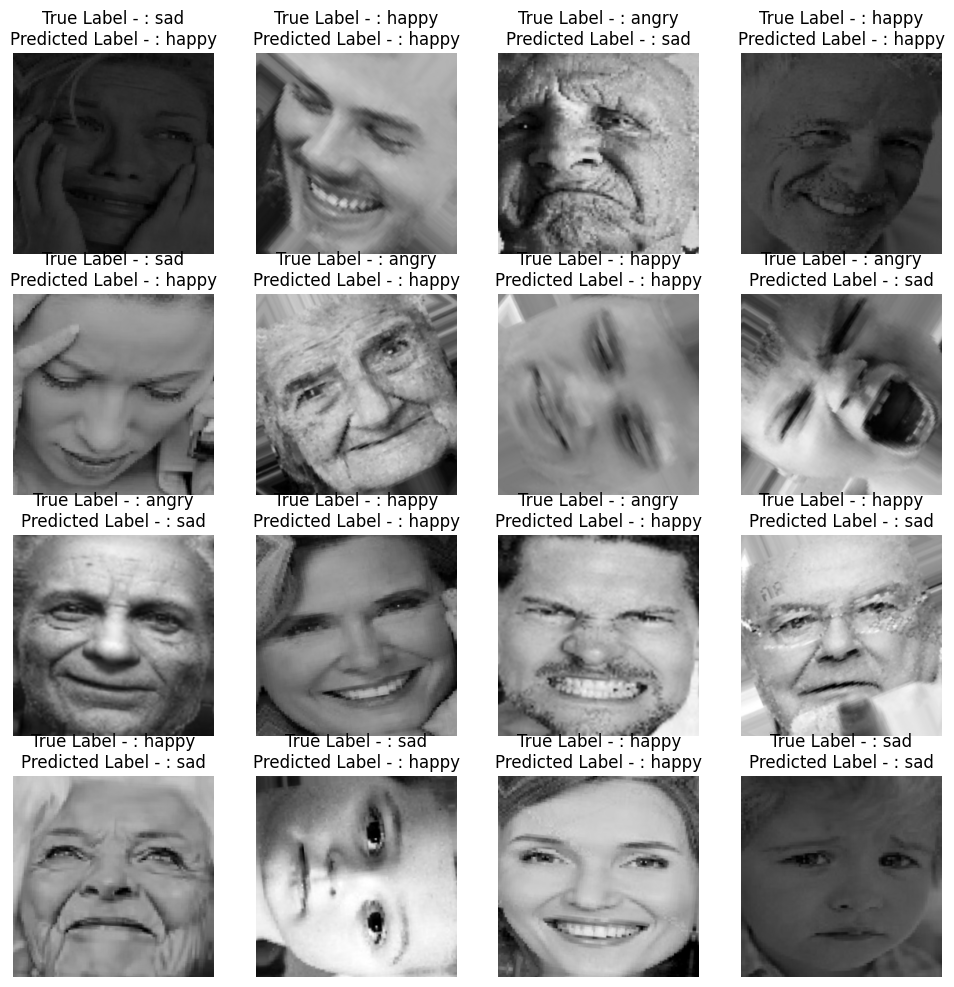

In [44]:
plt.figure(figsize = (12,12))

for images, labels in training_dataset.take(16):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
                  + "\n" + "Predicted Label - : "
                  + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(RESNet(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")